In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.applications.resnet import ResNet50, preprocess_input

In [2]:
dataset = tfds.builder('eurosat')
info = dataset.info
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='~/tensorflow_datasets/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    s

In [3]:
info.features

FeaturesDict({
    'filename': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

In [4]:
class_names = []

for i in range(info.features["label"].num_classes):
  class_names.append(info.features["label"].int2str(i))

class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [5]:
list(info.splits.keys())

['train']

**Load the data**

In [6]:
(train, val, test) = tfds.load("eurosat/rgb", split=["train[:80%]", "train[80%:90%]", "train[90%:]"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteM387MP/eurosat-train.tfrecord*...:   0%|          …

Dataset eurosat downloaded and prepared to ~/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [7]:
type(train)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [8]:
datapoint = next(iter(train))
# datapoint['image']

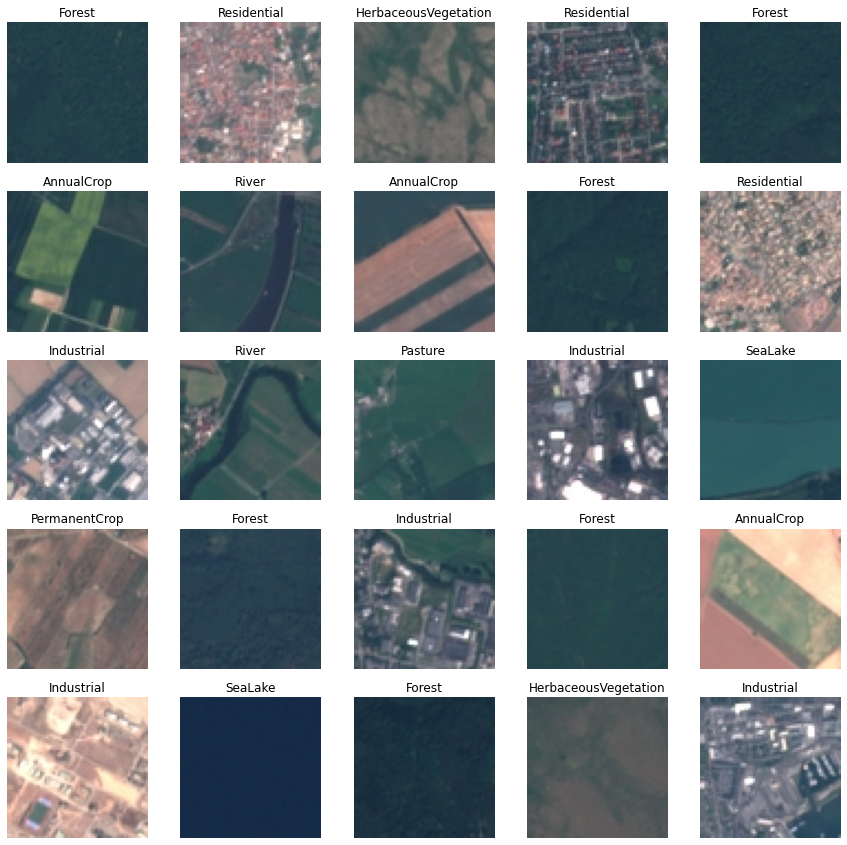

In [9]:
# investigate images
plt.figure(figsize=(15, 15))

for i, datapoint in enumerate(tfds.as_numpy(train.take(25))):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(datapoint["image"])
  plt.title(class_names[datapoint["label"]])
  plt.axis("off")
plt.show()

In [10]:
# define constatnt whihc will be used later
NUM_EPOCHS = 5
BATCH_SIZE = 128
BUFFER_SIZE = 1000

IMAGE_SHAPE = [180, 180]
NUM_CLASSES = info.features["label"].num_classes

In [21]:
# Data augmentation
def prepare_training_data(datapoint):
  input_image = tf.image.resize(datapoint['image'], IMAGE_SHAPE)

  if tf.random.uniform(()) > 0.50:
    input_image = tf.image.random_flip_left_right(input_image)
    input_image = tf.image.random_flip_up_down(input_image)
    input_image = tf.image.random_brightness(input_image, max_delta=3e-1)
    input_image = tf.image.random_saturation(input_image, lower=0.75, upper=1.50)
    input_image = tf.image.random_contrast(input_image, lower=0.75, upper=1.50)

  input_image = preprocess_input(input_image)

  return input_image, datapoint['label']

def prepare_validation_data(datapoint):
  input_image = tf.image.resize(datapoint['image'], IMAGE_SHAPE)
  input_image = preprocess_input(input_image)

  return input_image, datapoint['label']


In [12]:
from tensorflow.python.data.ops.dataset_ops import AUTOTUNE

train = train.map(prepare_training_data, num_parallel_calls=AUTOTUNE)
val = val.map(prepare_training_data)

train_ds = train.cache().shuffle(BATCH_SIZE).batch(BATCH_SIZE).repeat()
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = val.batch(BATCH_SIZE)

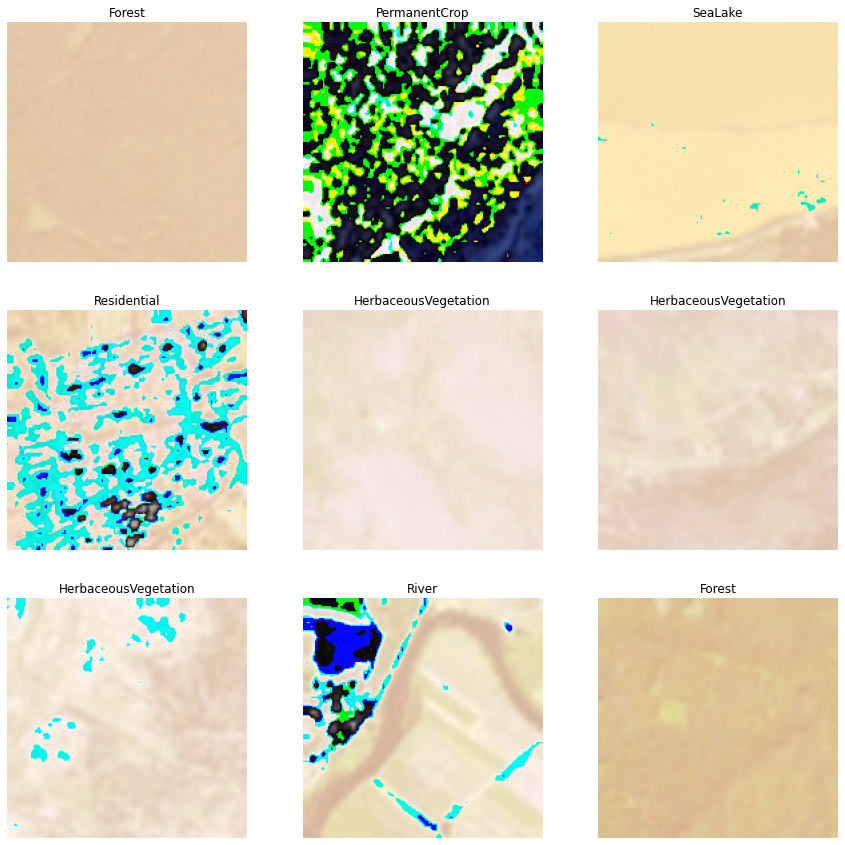

In [13]:
# investigate images after preprocess
plt.figure(figsize=(15, 15))
for i in range(9):
  ax = plt.subplot(3,3, i+1)
  for dp in tfds.as_numpy(train_ds.take(1)):
    plt.imshow(dp[0][0].astype('uint8'))
    plt.title(class_names[dp[1][0]])
    plt.axis('off')
plt.show()

## BUild moldel

In [14]:
resnet = ResNet50(input_shape=IMAGE_SHAPE+[3], weights='imagenet', include_top=False)

for l in resnet.layers:
  l.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(resnet.output)
x = tf.keras.layers.Flatten()(x)
pred = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.models.Model(inputs=resnet.input, outputs=pred)

94781440/94765736 [==============================] - 1s 0us/step


In [15]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

In [16]:
STEPS_PER_EPOCH = int(info.splits["train"].num_examples*0.80)//BATCH_SIZE
VALIDATION_STEPS = int(info.splits["train"].num_examples*0.10)//BATCH_SIZE

In [17]:
hist = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS
)

Epoch 1/5
168/168 [==============================] - 71s 330ms/step - loss: 0.4275 - accuracy: 0.8661
Epoch 2/5
168/168 [==============================] - 47s 274ms/step - loss: 0.1768 - accuracy: 0.9429
Epoch 3/5
168/168 [==============================] - 46s 273ms/step - loss: 0.1375 - accuracy: 0.9558
Epoch 4/5
168/168 [==============================] - 46s 273ms/step - loss: 0.1163 - accuracy: 0.9634
Epoch 5/5
168/168 [==============================] - 46s 273ms/step - loss: 0.1001 - accuracy: 0.9695


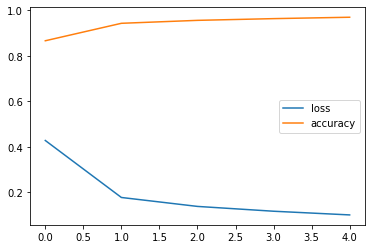

In [18]:
import pandas as pd

pd.DataFrame(
    hist.history
).plot()

## Evaluate Results

In [23]:
test_ds = test.map(prepare_validation_data)
test_ds = test_ds.batch(BATCH_SIZE)

In [25]:
model.evaluate(test_ds)

22/22 [==============================] - 9s 263ms/step - loss: 0.1297 - accuracy: 0.9581


[0.12974946200847626, 0.9581481218338013]

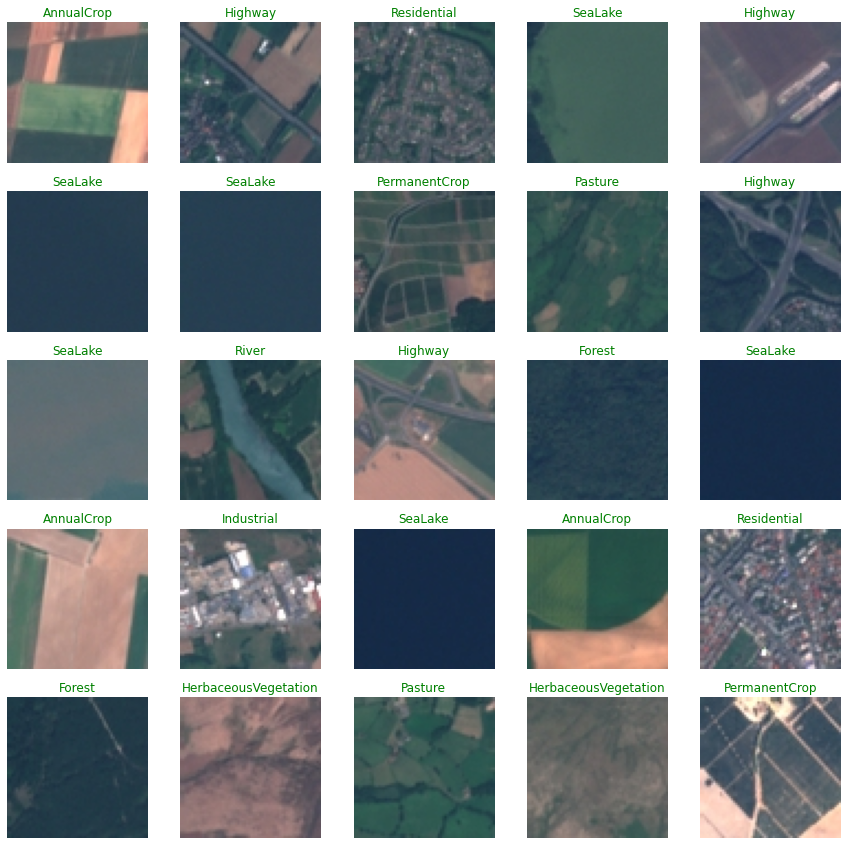

In [26]:
plt.figure(figsize=(15, 15))
for i, datapoint in enumerate(tfds.as_numpy(test.take(25))):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(datapoint["image"])
  image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)
  image = preprocess_input(image)
  image = np.expand_dims(image, axis=0)

  if datapoint["label"] == np.argmax(model.predict(image)):
    plt.title(class_names[np.argmax(model.predict(image))], color="green")
  else:
    plt.title(class_names[np.argmax(model.predict(image))], color="red")

  plt.axis("off")

plt.show()